### Data Preprocessing

#### Load Dataset

There are two fields in this dataset:

- text: the description of disease  review text.
- label: The disease category .



In [29]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns



from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# read the disease description 
df = pd.read_csv('combined.csv')
df.head()



,Description,Category,Unnamed: 2
0,I've been dealing with this huge pain in my ri...,heart disease,NaN
1,"Hello, doctor. I've been experiencing a persis...",heart disease,NaN
2,"Doctor, I've been experiencing some concerning...",heart disease,NaN
3,"Hey, doctor, I've been experiencing progressiv...",heart disease,NaN
4,"Hi, doctor, I've been feeling this pain on my ...",heart disease,NaN


In [31]:
df.info()
df = df[['Description','Category']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3202 entries, 0 to 3201
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  3202 non-null   object
 1   Category     3202 non-null   object
dtypes: object(2)
memory usage: 50.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3202 entries, 0 to 3201
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  3202 non-null   object
 1   Category     3202 non-null   object
dtypes: object(2)
memory usage: 50.2+ KB


<Axes: >

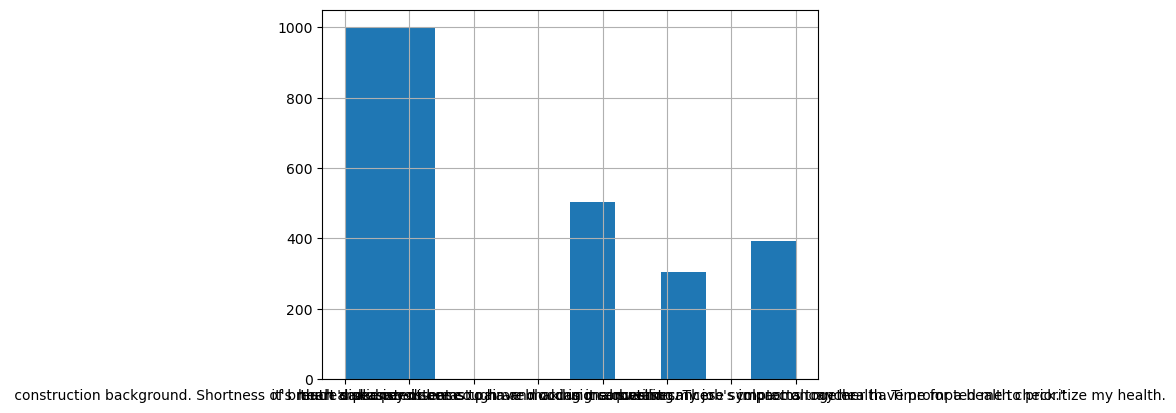

In [32]:
df.head()
df['Category'].hist()


Map classes to the integers

The first line defines a dictionary target_map that maps the original categorical target variable 'sentiment' to a numerical representation, with 'positive' mapped to 1, 'negative' mapped to 0 and ‘neutral’ mapped to 2.

In [57]:
'''
import os
from datasets import load_dataset


raw_datasets = load_dataset('csv', data_files='./corpus.csv')


os.environ['CUDA_VISIBLE_DEVICES'] = "3"
imdb = load_dataset("imdb")
imdb["test"][0]
'''

target_map = {"lung cancer" : 0,  "kidney disease":1  ,  "heart disease" : 2}
df['target'] = df['Category'].map(target_map)


df1 = df[['Description','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)
df1.head()


print("All sentence is:\n",df1.sentence.str.len())
print("Longest length is:\n",df1.sentence.str.len().max())



All sentence is:
 0       1226
1       1504
2       1624
3       1187
4        938
        ... 
3197     101
3198     144
3199     162
3200     173
3201     105
Name: sentence, Length: 3202, dtype: int64
Longest length is:
 2302


#### Tokenization

In [7]:
'''
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_imdb = imdb.map(preprocess_function, batched=True)
'''

from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files = 'data.csv')

raw_dataset



DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3202
    })
})

In [8]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

split



DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2241
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 961
    })
})

In [20]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


max_length = 2302

def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation = True, padding = True )

#print(split)

tokenized_dataset = split.map(tokenize_fn, batched = True)
print(tokenized_dataset)



Map:   0%|          | 0/2241 [00:00<?, ? examples/s]

Map:   0%|          | 0/961 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2241
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 961
    })
})


Split the Dataset to test and train
- test-size = 0.3
- seed = 42

In [21]:

tokenized_dataset


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2241
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 961
    })
})

In [28]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print(data_collator)

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')


Define tokenizer function



### Evaluation Metric

In [30]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Training

In [31]:
import torch
torch.cuda.is_available()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 4090


In [32]:
import torch

torch.cuda.device_count()
torch.cuda.current_device()



0

In [33]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

'''
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
'''

id2label = {0: "lung cancer", 1: "kidney disease" , 2: "heart disease"}

label2id = {"lung cancer" : 0,  "kidney disease": 1  , "heart disease" : 2}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", use_safetensors=False, num_labels=3 , id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="cached_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

  0%|          | 0/282 [00:00<?, ?it/s]

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`label` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

### Inference

In [9]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="stevhliu/my_awesome_model")
classifier(text)

config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

NameError: name 'text' is not defined

In [10]:
from transformers import pipeline, AutoModel, AutoTokenizer

# Replace with your custom model of choice
model = AutoModelForSequenceClassification.from_pretrained(
    './cached_model/checkpoint-3126'
)
tokenizer = AutoTokenizer.from_pretrained('./cached_model/checkpoint-3126')

pipe = pipeline(
    task="text-classification",  # replace with whatever task you have
    model=model,
    tokenizer=tokenizer
)

In [11]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."
pipe(text)

[{'label': 'POSITIVE', 'score': 0.9970191717147827}]